In [463]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Linear classifer with Hinge Loss

Set a seed for reproducibility:

In [464]:
SEED = 42

In [465]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(SEED)

## Classification model

Let $\mathbf{W}_{(d+1)\times k} = [\mathbf{w}_1, \mathbf{w}_2, \ldots, \mathbf{w}_k]$ be the weight matrix, where $\mathbf{w}_i$ is the weight vector for class $i \in \{1, 2, \ldots, k\}$ augmented with the bias term. The scores $\mathbf{z} = [z_1, \ldots, z_k]^T$ computed for the linear model for an input $\mathbf{x}$ are given by

$$
\mathbf{z} = \mathbf{W}^T \mathbf{x},
$$

where $z_i$ is the score for class $i$. The predicted class is the one with the highest score, i.e., $\hat{y} = \text{argmax}_i z_i$.

In [466]:
W = np.random.randn(5, 3) # 4 features + 1 bias, 3 classes
x = np.random.randn(5, 1) # 4 features + 1 bias
x[-1] = 1 # bias
z = np.dot(W.T, x) # 3 classes 

print(f"x:\n {x}\n")
print(f"z:\n {z}")
print(f"predicted class: {np.argmax(z)}")

x:
 [[-0.56228753]
 [-1.01283112]
 [ 0.31424733]
 [-0.90802408]
 [ 1.        ]]

z:
 [[-1.57630011]
 [-0.93641939]
 [-1.57660107]]
predicted class: 1


## Optimization model

### The Hinge Loss

The hinge loss for a single example $(\mathbf{x}_i, y_i)$ is given by

$$
\begin{align*}
L_i & = \sum_{j \neq y_i}^k \begin{cases}
0 & \text{if } z_{y_i} \geq z_j + 1, \\
z_j - z_{y_i} + 1 & \text{otherwise}.
\end{cases}\\
& = \sum_{j \neq y_i}^k \max(0, z_j - z_{y_i} + 1).
\end{align*}
$$

where $y_i$ is the true class label and $k$ is the number of classes.

In [467]:
def hinge_loss(z, class_idx):
    """Compute the hinge loss for a single exemplar.

    Args:
        z: the predicted class scores.
        class_idx: the index of the true class.
    """
    z_true = z[class_idx, 0]
    loss = np.maximum(0, z - z_true + 1)
    loss[class_idx] = 0
    return loss.sum()

def hinge_grad(z, class_idx):
    """Compute the gradient of the hinge loss wrt the predicted class scores.

    Args:
        z: the predicted class scores.
        class_idx: the index of the true class.
    """
    z_true = z[class_idx, 0]
    grad = np.zeros_like(z)
    grad[z - z_true + 1 > 0] = 1
    grad[class_idx] = 0 # do not account for the true class
    grad[class_idx] = -np.sum(grad) # sum over all classes
    return grad

Example:

In [469]:
predicted_class_idx = np.argmax(z)
class_idx = 1
loss = hinge_loss(z, class_idx)
grad = hinge_grad(z, class_idx)

print(f"z:\n {z}")
print(f"\npredicted class: {predicted_class_idx}")
print(f"\nloss: {loss}")
print(f"\ngrad:\n {grad}")

z:
 [[-1.57630011]
 [-0.93641939]
 [-1.57660107]]

predicted class: 1

loss: 0.7199376040598662

grad:
 [[ 1.]
 [-2.]
 [ 1.]]


To backpropagate the gradient to the linear layer weights, we must define the gradient of the scores with respect to the hinge loss:

In [447]:
def linear_gradW(grad_output, x):
    """Compute the gradient of the loss wrt the output of a linear layer.

    Args:
        grad_output: the gradient of the loss wrt the output of the linear layer.
        x: the input of the linear layer.
    """
    grad = np.dot(x, grad_output.T)
    return grad

Train set size: 800
Test set size: 200
X_train_min: -2.7006378421518584, X_train_max: 3.056834530918784
ymin: 0, ymax: 2


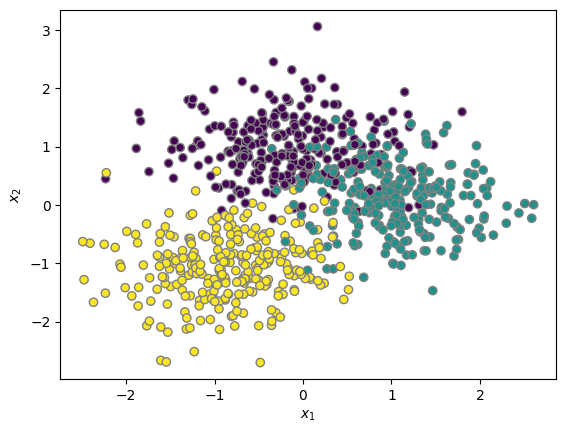

In [448]:
from utils import make_classification_dataset, standard_scaler
from sklearn.model_selection import train_test_split

np.random.seed(SEED)

num_classes = 3  # number
X, y = make_classification_dataset(1000, 2, num_classes, cluster_std=4)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize X
X_train, mean, std = standard_scaler(X_train)
X_test, _, _ = standard_scaler(X_test, mean, std)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Plot the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="gray")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

print(f"X_train_min: {X_train.min()}, X_train_max: {X_train.max()}")

print(f"ymin: {y.min()}, ymax: {y.max()}")

### Training

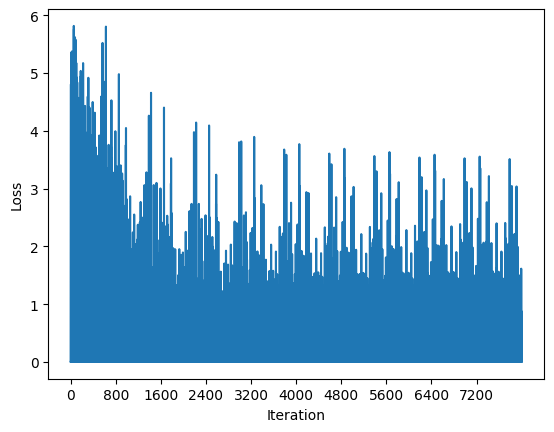

In [449]:
from utils import plot_loss_history

np.random.seed(SEED)

num_epochs = 10
learning_rate = 1e-03

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Random weights initialization
W = np.random.normal(size=(X_b.shape[1], num_classes)) # 2 features + 1 bias, 3 classes

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    for k in range(len(X_b)):
        x = X_b[k].reshape(-1, 1) # make it a column vector

        # Forward pass (scores)
        z = np.dot(W.T, x)

        # Loss
        correct_class = y_train[k]
        loss_value = hinge_loss(z, correct_class)
        loss_history.append(loss_value)

        # Backward pass
        grad_output = hinge_grad(z, correct_class)
        grad_W = linear_gradW(grad_output, x)

        # Update weights
        W -= learning_rate * grad_W

        iteration += 1
plot_loss_history(loss_history, interval=iteration//10)

### Test

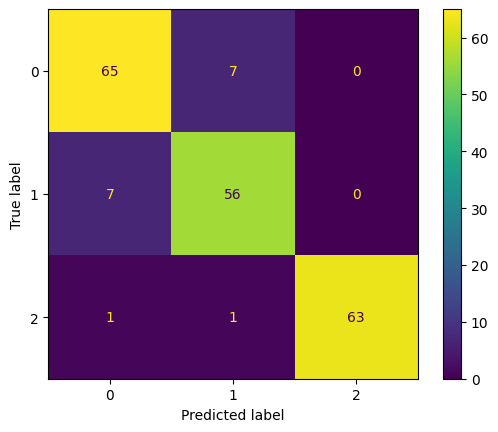


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        72
           1       0.88      0.89      0.88        63
           2       1.00      0.97      0.98        65

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [450]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

X_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

y_pred = []
for k in range(len(X_b)):
    x = X_b[k].reshape(-1, 1)  # make it a column vector
    z = np.dot(W.T, x)
    y_pred.append(np.argmax(z))
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

### A batch gradient descent approach

#### Loss

For batch gradient descent, the loss is given by

$$
\begin{align*}
L &= \frac{1}{N} \sum_{i=1}^N L_i \\
  &= \frac{1}{N} \sum_{i=1}^{N} \sum_{j \neq i}^k \max(0, \mathbf{z}_j - \mathbf{z}_{y_i} + 1),
\end{align*}
$$

where $N$ is the number of training examples.

#### Gradient

In a backpropagation approach, we must compute the gradient of the hinge loss with respect to the weights using the chain rule:

$$
\frac{\partial L}{\partial \mathbf{W}} = \frac{\partial L}{\partial \mathbf{Z}} \frac{\partial \mathbf{Z}}{\partial \mathbf{W}},
$$

where $\frac{\partial L}{\partial \mathbf{Z}}$ is the gradient of the hinge loss with respect to the scores and $\frac{\partial \mathbf{Z}}{\partial \mathbf{W}}$ is the gradient of the scores with respect to the weights. The solution for this derivative is given by

$$
\frac{\partial L}{\partial \mathbf{W}} = \mathbf{X}^T \frac{\partial L}{\partial \mathbf{Z}}.
$$

For the complete derivation, see [here](https://cs231n.stanford.edu/handouts/linear-backprop.pdf).

To calculate $\frac{\partial L}{\partial \mathbf{Z}}$, we must first compute the gradient of the hinge loss with respect to the scores:

$$
\begin{align*}
\frac{\partial L}{\partial z_{n,k}} & = \frac{1}{N} \sum_{i=1}^N \frac{\partial L_i}{\partial z_{n,k}} \\
                                       & = \frac{1}{N} \frac{\partial L_n}{\partial z_{n,k}}.
\end{align*}
$$

The equation above can be rewritten as

$$
\frac{\partial L}{\partial \mathbf{Z}} = \frac{1}{N} \mathbf{H},
$$ 

where $\mathbf{H}$ is the hinge loss gradient matrix (each entry $(n,k)$ represents $\frac{\partial L_n}{z_{n,k}}$).

In summary,

$$
\frac{\partial L}{\partial \mathbf{W}} = \mathbf{X}^T \left(\frac{1}{N} \mathbf{H}\right).
$$

In [451]:
def hinge_loss(Z, class_idxs):
    """Compute the hinge loss for a batch of exemplars.

    Args:
        Z: the predicted class scores.
        class_idxs: the indices of the true classes.
    """

    Z_true = Z[np.arange(len(class_idxs)), class_idxs]
    loss = np.maximum(0, Z - Z_true[:, np.newaxis] + 1) # loss[n, k] = contrib of z_nk to L_n
    loss[np.arange(len(class_idxs)), class_idxs] = 0 # do not account for the true classes
    return loss.sum(axis=1).mean() 


def hinge_grad(Z, class_idxs):
    """Compute the gradient of the hinge loss wrt the predicted class scores.

    Args:
        Z: the predicted class scores.
        class_idxs: the indices of the true classes.
    """

    Z_true = Z[np.arange(len(class_idxs)), class_idxs]
    H = np.zeros_like(Z) 
    H[Z - Z_true[:, np.newaxis] + 1 > 0] = 1
    H[np.arange(len(class_idxs)), class_idxs] = 0 # do not account for the true classes
    H[np.arange(len(class_idxs)), class_idxs] = -np.sum(H, axis=1) # sum over all classes 
    grad = H / len(class_idxs) # average based on the loss definition
    return grad


def linear_gradW(grad_output, X):
    """Compute the gradient of the loss wrt the output of a linear layer.
    Refer to https://cs231n.stanford.edu/handouts/linear-backprop.pdf for more details.

    Args:
        grad_output: the gradient of the loss wrt the output of the linear layer.
        X: the input of the linear layer.
    """
    grad = np.dot(X.T, grad_output)
    return grad

### Training

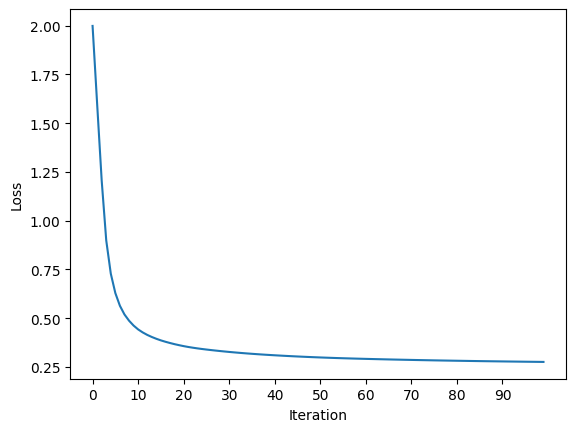

In [452]:
np.random.seed(SEED)

# Adjust the number of epochs and the learning rate
num_epochs = 100
learning_rate = 1e-01

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Random weights initialization
W = np.random.normal(size=(X_b.shape[1], num_classes)) * 0.001  # 2 features + 1 bias, 3 classes

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    # Forward pass
    Z = np.dot(X_b, W) # scores for all examples, all classes

    # Loss
    loss_value = hinge_loss(Z, y_train) # average loss over all examples (scalar)
    loss_history.append(loss_value)

    # Backward pass
    grad_output = hinge_grad(Z, y_train)
    grad_W = linear_gradW(grad_output, X_b)

    # Update weights
    W -= learning_rate * grad_W

    iteration += 1

plot_loss_history(loss_history, interval=iteration // 10)

### Test

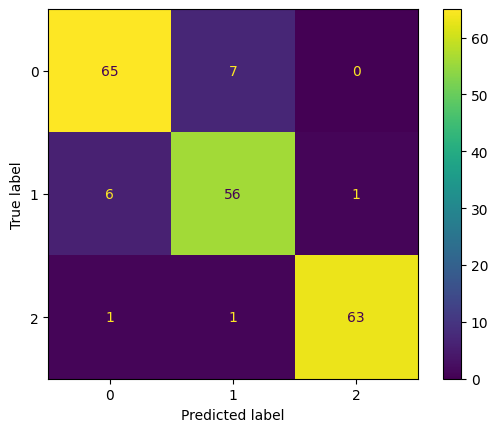


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        72
           1       0.88      0.89      0.88        63
           2       0.98      0.97      0.98        65

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [453]:
X_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
Z = np.dot(X_b, W)
y_pred = np.argmax(Z, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

## Case study: Image classification

In this case study, we will use the CIFAR-10 dataset. CIFAR-10 consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class: 5,000 for training and 1,000 for testing. The classes are airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

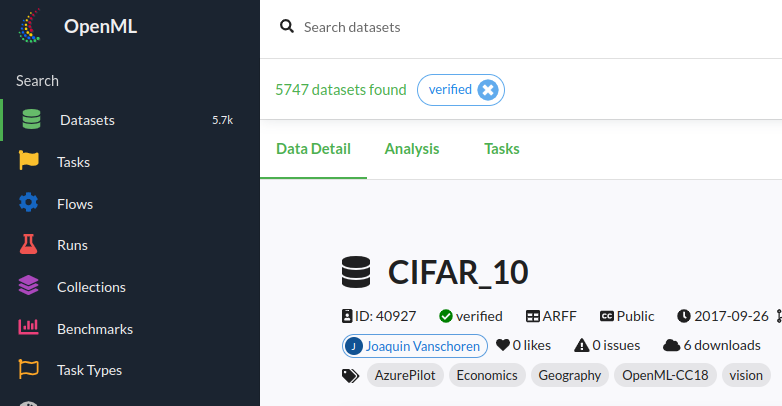

In [454]:
# If True, test is running on Colab. Otherwise, test if assumed to be offline.
TEST_ON_COLAB = False
FOLDERNAME = None  # only used if TEST_ON_COLAB is True
# FOLDERNAME = "Colab Notebooks/ann/11_multinomial-regression-hinge-loss"

assert not (FOLDERNAME is None and TEST_ON_COLAB), "FOLDERNAME has to be set if TEST_ON_COLAB is True"

### Dataset

In [455]:
DATASET_OPENML_ID = "CIFAR_10" # try to use a dataset that is already in the OpenML-CC18 benchmark

assert DATASET_OPENML_ID is not None, "DATASET_OPENML_ID is not set"

Downloading the dataset:

In [456]:
# Create dataset directory
import os

if TEST_ON_COLAB:
    # This mounts your Google Drive to the Colab VM.
    from google.colab import drive

    drive.mount("/content/drive")
    cache_dir = f"/content/drive/My Drive/{FOLDERNAME}/dataset/{DATASET_OPENML_ID}"
else:
    cache_dir = f"dataset/{DATASET_OPENML_ID}"

os.makedirs(cache_dir, exist_ok=True)

# Fetching the dataset
from sklearn.datasets import fetch_openml

X_file_path = f"{cache_dir}/X.npy"
y_file_path = f"{cache_dir}/y.npy"

# Check if the dataset files already exist
if not (os.path.exists(X_file_path) and os.path.exists(y_file_path)):
    # Fetch the dataset where X is the data and y is the target
    X, y = fetch_openml(DATASET_OPENML_ID, as_frame=False, cache=True, return_X_y=True)

    # Save the dataset as numpy arrays
    np.save(X_file_path, X.astype(np.float32))
    np.save(y_file_path, y)
    print(f"{DATASET_OPENML_ID} dataset downloaded and saved successfully to {cache_dir}.")
else:
    X = np.load(X_file_path, allow_pickle=True)
    y = np.load(y_file_path, allow_pickle=True)
    print(f"{DATASET_OPENML_ID} dataset already exists in {cache_dir}. Skipping download.")

print(X.shape)
print(X.min(), X.max())

CIFAR_10 dataset already exists in dataset/CIFAR_10. Skipping download.
(60000, 3072)
0.0 255.0


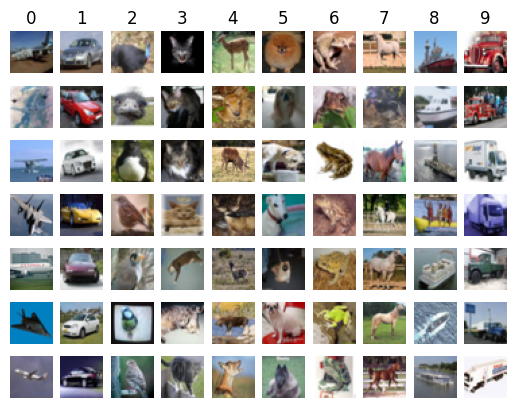

In [457]:
import numpy as np
import matplotlib.pyplot as plt

# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = [i for i in range(10)]
num_classes = len(classes)
samples_per_class = 7
for cls in classes:
    idxs = np.flatnonzero(y == str(cls))
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + cls + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].reshape((3, 32, 32)).transpose(1, 2, 0).astype("uint8"))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

Split dataset intro train and test sets.

In [458]:
np.random.seed(SEED)

y = np.array([int(label) for label in y])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Scale to 0-1 and standardize
X_train /= 255
X_test /= 255
X_train, mean, std = standard_scaler(X_train)
X_test, _, _ = standard_scaler(X_test, mean, std)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

print(f"X_train_min: {X_train.min()}, X_train_max: {X_train.max()}")

print(f"ymin: {y.min()}, ymax: {y.max()}")

Train set size: 54000
Test set size: 6000
X_train_min: -2.2040276527404785, X_train_max: 2.6324617862701416
ymin: 0, ymax: 9


### Training

Training:   0%|          | 0/50 [00:00<?, ?it/s]

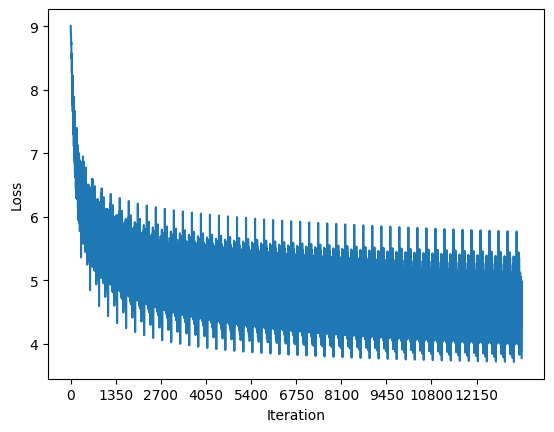

In [459]:
from tqdm.notebook import tqdm

np.random.seed(SEED)

num_epochs = 50
learning_rate = 1e-05
batch_size = 200

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Random weights initialization
W = np.random.normal(size=(X_b.shape[1], num_classes)) * 0.0001
iteration = 0
loss_history = []

# Training loop
pbar = tqdm(total=num_epochs, desc="Training: ")
for epochs in range(num_epochs):

    # Update the progress bar after each iteration
    pbar.update(1)

    for i in range(0, len(X_b), batch_size):
        X_batch = X_b[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        # Forward pass
        Z_batch = np.dot(X_batch, W)

        # Loss
        loss_value = hinge_loss(Z_batch, y_batch) 
        loss_history.append(loss_value)

        # Backward pass
        grad_output = hinge_grad(Z_batch, y_batch)
        grad_W = linear_gradW(grad_output, X_batch)

        # Update weights
        W -= learning_rate * grad_W

        iteration += 1

    pbar.set_description(f"Training: Epoch loss: {loss_value:.3f}")

plot_loss_history(loss_history, interval=iteration // 10)

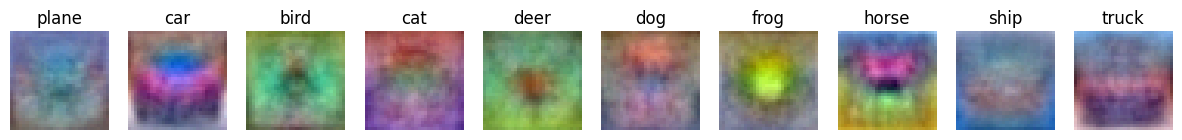

In [460]:
# Visualize templates of each class.
W_view = W[:-1] # exclude the bias term
W_view = W_view.reshape((3, 32, 32, 10)).transpose(1, 2, 0, 3) # reshape and permute dimensions

# Normalize the templates
w_min, w_max = W_view.min(), W_view.max()
W_view = (W_view - w_min) / (w_max - w_min)

fig, ax = plt.subplots(1, num_classes, figsize=(15, 5))
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for cls in range(num_classes):
    plt.subplot(1, num_classes, cls + 1)
    plt.imshow(W_view[..., cls])
    plt.axis("off")
    plt.title(classes[cls])
plt.show()

### Test

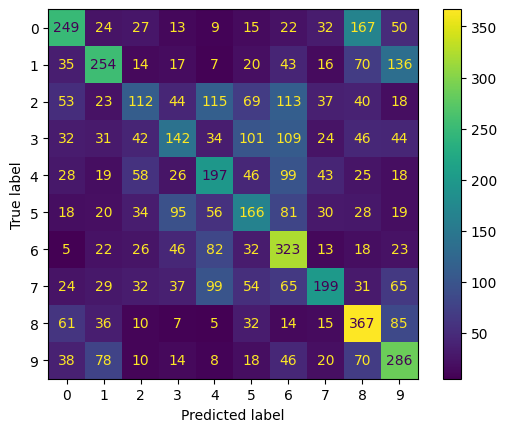


Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.41      0.43       608
           1       0.47      0.42      0.44       612
           2       0.31      0.18      0.23       624
           3       0.32      0.23      0.27       605
           4       0.32      0.35      0.34       559
           5       0.30      0.30      0.30       547
           6       0.35      0.55      0.43       590
           7       0.46      0.31      0.37       635
           8       0.43      0.58      0.49       632
           9       0.38      0.49      0.43       588

    accuracy                           0.38      6000
   macro avg       0.38      0.38      0.37      6000
weighted avg       0.38      0.38      0.37      6000



In [461]:
X_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) # add bias term
Z = np.dot(X_b, W) # scores for all examples, all classes
y_pred = np.argmax(Z, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)